<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# Machine Learning Foundation

## Course 5, Part d: Keras Intro LAB


## Using Keras to Build and Train Neural Networks


In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## UCI Pima Diabetes Dataset

* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)


The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.


In [1]:
#Setup
import warnings
import skillsnetwork

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
## Import Keras objects for Deep Learning
from keras.models  import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

In [3]:
## Load in the data set 
#await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module2/L2/diabetes.csv", overwrite=True)

names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv('./diabetes.csv', names=names, header=0)

In [4]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
699,4,118,70,0,0,44.5,0.904,26,0
669,9,154,78,30,100,30.9,0.164,45,0
446,1,100,72,12,70,25.3,0.658,28,0
199,4,148,60,27,318,30.9,0.150,29,1
681,0,162,76,36,0,49.6,0.364,26,1


In [5]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [6]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

In [7]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise 1: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.


In [8]:
### BEGIN SOLUTION
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [12]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.745
roc-auc is 0.823


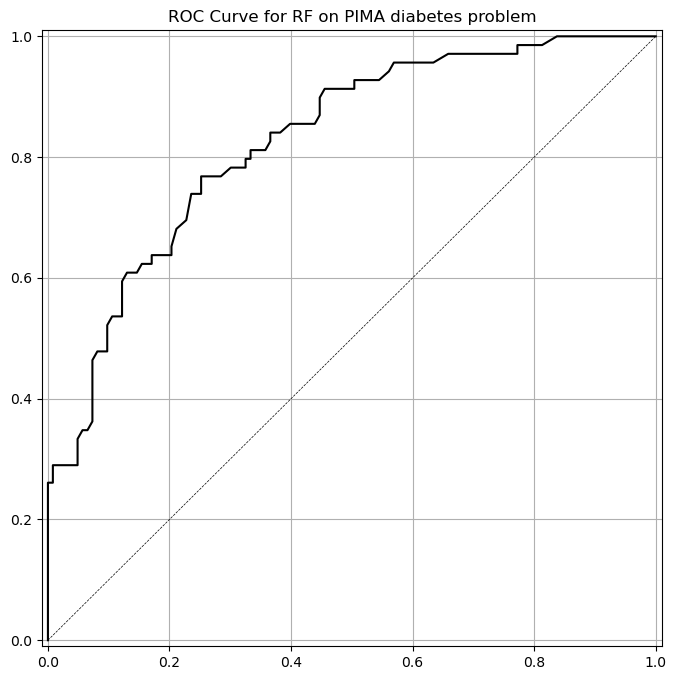

In [10]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')
### END SOLUTION

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 12 nodes.


In [11]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [12]:
# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

model_1 = Sequential()
model_1.add(Dense(12,input_shape = (8,),activation = 'sigmoid'))
model_1.add(Dense(1,activation='sigmoid'))

In [13]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12)                  │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              13 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121 (484.00 B)

 Trainable params: 121 (484.00 B)

 Non-trainable params: 0 (0.00 B)

### Comprehension question:
Why do we have 121 parameters?  Does that make sense?

Let's fit our model for 200 epochs.


In [14]:
# Compile the model with Optimizer, Loss Function, and Metrics
# Roc-Auc is not available in Keras as an off-the-shelf metric yet, so we will skip it here.

model_1.compile(optimizer=SGD(learning_rate=0.003), loss="binary_crossentropy",metrics=["accuracy"])

# Train (fit) the model
run_hist_1 = model_1.fit( X_train_norm, y_train,validation_data=(X_test_norm, y_test),epochs=200)

# The fit function returns the run history, 
# which is useful for tracking model performance across epochs.


Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4629 - loss: 0.7230 - val_accuracy: 0.5417 - val_loss: 0.7135
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4710 - loss: 0.7374 - val_accuracy: 0.5625 - val_loss: 0.7090
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4724 - loss: 0.7292 - val_accuracy: 0.5885 - val_loss: 0.7049
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5246 - loss: 0.7161 - val_accuracy: 0.5990 - val_loss: 0.7012
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5228 - loss: 0.7137 - val_accuracy: 0.5885 - val_loss: 0.6979
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5668 - loss: 0.6990 - val_accuracy: 0.5833 - val_loss: 0.6948
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5465 - loss: 0.7141 - val_accuracy: 0.5885 - val_loss: 0.6920
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5642 - loss: 0.6995 - val_accuracy: 0.6042 - 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6837 - loss: 0.6064 - val_accuracy: 0.6667 - val_loss: 0.6226
Epoch 102/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6600 - loss: 0.6298 - val_accuracy: 0.6667 - val_loss: 0.6221
Epoch 103/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6829 - loss: 0.6135 - val_accuracy: 0.6667 - val_loss: 0.6216
Epoch 104/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6903 - loss: 0.6019 - val_accuracy: 0.6719 - val_loss: 0.6212
Epoch 105/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6734 - loss: 0.6133 - val_accuracy: 0.6719 - val_loss: 0.6207
Epoch 106/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6543 - loss: 0.6355 - val_accuracy: 0.6719 - val_loss: 0.6203
Epoch 107/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6377 - loss: 0.6355 - val_accuracy: 0.6771 - val_loss: 0.6198
Epoch 108/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6491 - loss: 0.6344 - val_accuracy: 0.6771 -

In [15]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_prob_nn_1 = model_1.predict(X_test_norm)
y_pred_class_nn_1 = (y_pred_prob_nn_1 > 0.5).astype(int)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [16]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [17]:
y_pred_prob_nn_1[:10]

array([[0.4248802 ],
       [0.5184644 ],
       [0.30220425],
       [0.4472733 ],
       [0.26513234],
       [0.3436284 ],
       [0.2469022 ],
       [0.49575529],
       [0.48367196],
       [0.34352845]], dtype=float32)

accuracy is 0.724
roc-auc is 0.737


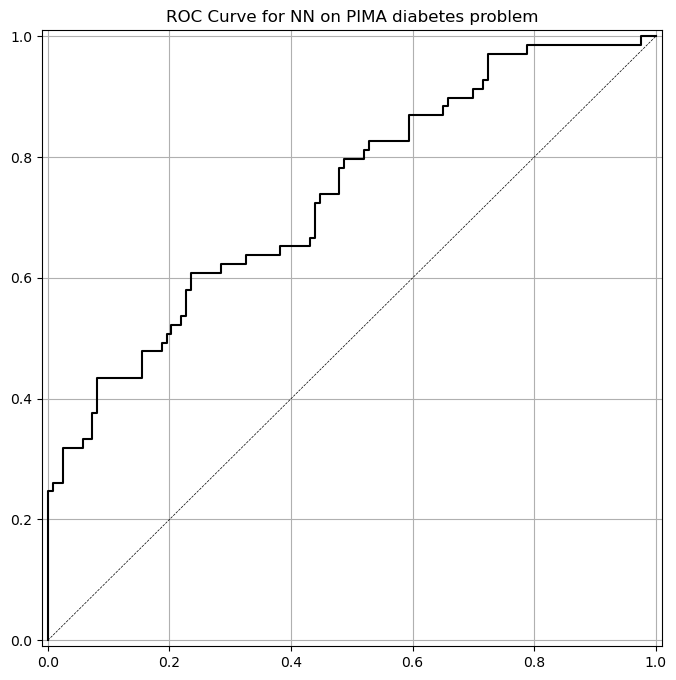

In [18]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.


Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.


In [19]:
run_hist_1.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.


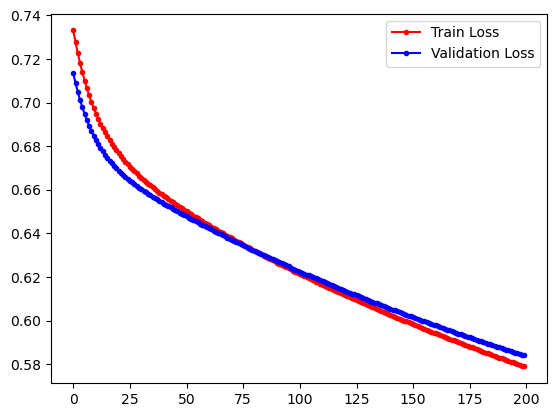

In [20]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.


In [21]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

Epoch 1/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6532 - loss: 0.5944 - val_accuracy: 0.7240 - val_loss: 0.5837
Epoch 2/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6870 - loss: 0.5691 - val_accuracy: 0.7292 - val_loss: 0.5834
Epoch 3/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6792 - loss: 0.5761 - val_accuracy: 0.7292 - val_loss: 0.5831
Epoch 4/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6402 - loss: 0.6076 - val_accuracy: 0.7292 - val_loss: 0.5827
Epoch 5/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6784 - loss: 0.5736 - val_accuracy: 0.7292 - val_loss: 0.5824
Epoch 6/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6709 - loss: 0.5943 - val_accuracy: 0.7292 - val_loss: 0.5821
Epoch 7/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6884 - loss: 0.5778 - val_accuracy: 0.7292 - val_loss: 0.5817
Epoch 8/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6731 - loss: 0.6030 - val_accuracy: 0.

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6893 - loss: 0.5488 - val_accuracy: 0.7344 - val_loss: 0.5547
Epoch 102/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7402 - loss: 0.5216 - val_accuracy: 0.7344 - val_loss: 0.5544
Epoch 103/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6946 - loss: 0.5450 - val_accuracy: 0.7344 - val_loss: 0.5542
Epoch 104/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6993 - loss: 0.5459 - val_accuracy: 0.7344 - val_loss: 0.5539
Epoch 105/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6887 - loss: 0.5445 - val_accuracy: 0.7344 - val_loss: 0.5537
Epoch 106/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7013 - loss: 0.5510 - val_accuracy: 0.7344 - val_loss: 0.5534
Epoch 107/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7208 - loss: 0.5342 - val_accuracy: 0.7344 - val_loss: 0.5532
Epoch 108/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7015 - loss: 0.5502 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7131 - loss: 0.5470 - val_accuracy: 0.7344 - val_loss: 0.5430
Epoch 152/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7158 - loss: 0.5405 - val_accuracy: 0.7344 - val_loss: 0.5428
Epoch 153/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7226 - loss: 0.5360 - val_accuracy: 0.7344 - val_loss: 0.5426
Epoch 154/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7236 - loss: 0.5300 - val_accuracy: 0.7344 - val_loss: 0.5424
Epoch 155/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7203 - loss: 0.5417 - val_accuracy: 0.7344 - val_loss: 0.5421
Epoch 156/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7178 - loss: 0.5382 - val_accuracy: 0.7396 - val_loss: 0.5419
Epoch 157/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6951 - loss: 0.5565 - val_accuracy: 0.7396 - val_loss: 0.5417
Epoch 158/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7201 - loss: 0.5342 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7288 - loss: 0.5120 - val_accuracy: 0.7448 - val_loss: 0.5330
Epoch 202/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7369 - loss: 0.5083 - val_accuracy: 0.7448 - val_loss: 0.5329
Epoch 203/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7089 - loss: 0.5342 - val_accuracy: 0.7448 - val_loss: 0.5327
Epoch 204/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7515 - loss: 0.5139 - val_accuracy: 0.7448 - val_loss: 0.5325
Epoch 205/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7165 - loss: 0.5415 - val_accuracy: 0.7448 - val_loss: 0.5323
Epoch 206/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7206 - loss: 0.5295 - val_accuracy: 0.7448 - val_loss: 0.5321
Epoch 207/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7470 - loss: 0.5148 - val_accuracy: 0.7396 - val_loss: 0.5320
Epoch 208/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7424 - loss: 0.5175 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7371 - loss: 0.5158 - val_accuracy: 0.7448 - val_loss: 0.5246
Epoch 252/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7223 - loss: 0.5225 - val_accuracy: 0.7448 - val_loss: 0.5245
Epoch 253/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7493 - loss: 0.5003 - val_accuracy: 0.7448 - val_loss: 0.5243
Epoch 254/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7375 - loss: 0.5191 - val_accuracy: 0.7448 - val_loss: 0.5242
Epoch 255/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7464 - loss: 0.5054 - val_accuracy: 0.7448 - val_loss: 0.5240
Epoch 256/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7479 - loss: 0.4958 - val_accuracy: 0.7500 - val_loss: 0.5239
Epoch 257/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7429 - loss: 0.5093 - val_accuracy: 0.7500 - val_loss: 0.5237
Epoch 258/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7496 - loss: 0.5083 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7406 - loss: 0.5118 - val_accuracy: 0.7708 - val_loss: 0.5176
Epoch 302/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7742 - loss: 0.4903 - val_accuracy: 0.7708 - val_loss: 0.5175
Epoch 303/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7295 - loss: 0.5206 - val_accuracy: 0.7708 - val_loss: 0.5174
Epoch 304/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7596 - loss: 0.5016 - val_accuracy: 0.7708 - val_loss: 0.5172
Epoch 305/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7609 - loss: 0.4939 - val_accuracy: 0.7708 - val_loss: 0.5171
Epoch 306/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7511 - loss: 0.5158 - val_accuracy: 0.7708 - val_loss: 0.5170
Epoch 307/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7736 - loss: 0.4677 - val_accuracy: 0.7708 - val_loss: 0.5169
Epoch 308/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7646 - loss: 0.4780 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7477 - loss: 0.5137 - val_accuracy: 0.7656 - val_loss: 0.5118
Epoch 352/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7230 - loss: 0.5116 - val_accuracy: 0.7656 - val_loss: 0.5117
Epoch 353/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7635 - loss: 0.4879 - val_accuracy: 0.7604 - val_loss: 0.5116
Epoch 354/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7453 - loss: 0.4869 - val_accuracy: 0.7604 - val_loss: 0.5115
Epoch 355/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7329 - loss: 0.4951 - val_accuracy: 0.7604 - val_loss: 0.5114
Epoch 356/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7368 - loss: 0.5015 - val_accuracy: 0.7604 - val_loss: 0.5113
Epoch 357/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7174 - loss: 0.5128 - val_accuracy: 0.7604 - val_loss: 0.5112
Epoch 358/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7617 - loss: 0.4907 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7619 - loss: 0.4645 - val_accuracy: 0.7656 - val_loss: 0.5070
Epoch 402/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7588 - loss: 0.4727 - val_accuracy: 0.7656 - val_loss: 0.5070
Epoch 403/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7552 - loss: 0.4884 - val_accuracy: 0.7656 - val_loss: 0.5069
Epoch 404/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7515 - loss: 0.4814 - val_accuracy: 0.7656 - val_loss: 0.5068
Epoch 405/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7479 - loss: 0.4843 - val_accuracy: 0.7656 - val_loss: 0.5067
Epoch 406/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7407 - loss: 0.4983 - val_accuracy: 0.7656 - val_loss: 0.5066
Epoch 407/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7433 - loss: 0.4930 - val_accuracy: 0.7656 - val_loss: 0.5065
Epoch 408/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7450 - loss: 0.5022 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7667 - loss: 0.4827 - val_accuracy: 0.7604 - val_loss: 0.5031
Epoch 452/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7594 - loss: 0.4851 - val_accuracy: 0.7604 - val_loss: 0.5031
Epoch 453/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7681 - loss: 0.4653 - val_accuracy: 0.7604 - val_loss: 0.5030
Epoch 454/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7521 - loss: 0.4814 - val_accuracy: 0.7604 - val_loss: 0.5029
Epoch 455/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7631 - loss: 0.4731 - val_accuracy: 0.7604 - val_loss: 0.5029
Epoch 456/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7265 - loss: 0.5053 - val_accuracy: 0.7604 - val_loss: 0.5028
Epoch 457/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7335 - loss: 0.5017 - val_accuracy: 0.7604 - val_loss: 0.5027
Epoch 458/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7461 - loss: 0.4849 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7230 - loss: 0.5218 - val_accuracy: 0.7656 - val_loss: 0.5000
Epoch 502/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7698 - loss: 0.4738 - val_accuracy: 0.7656 - val_loss: 0.4999
Epoch 503/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7395 - loss: 0.4884 - val_accuracy: 0.7656 - val_loss: 0.4998
Epoch 504/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7355 - loss: 0.4993 - val_accuracy: 0.7656 - val_loss: 0.4998
Epoch 505/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7471 - loss: 0.4948 - val_accuracy: 0.7656 - val_loss: 0.4997
Epoch 506/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7367 - loss: 0.4992 - val_accuracy: 0.7656 - val_loss: 0.4997
Epoch 507/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7463 - loss: 0.4908 - val_accuracy: 0.7656 - val_loss: 0.4996
Epoch 508/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7797 - loss: 0.4585 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7819 - loss: 0.4603 - val_accuracy: 0.7656 - val_loss: 0.4974
Epoch 552/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7557 - loss: 0.4723 - val_accuracy: 0.7656 - val_loss: 0.4973
Epoch 553/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7714 - loss: 0.4639 - val_accuracy: 0.7656 - val_loss: 0.4973
Epoch 554/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7439 - loss: 0.4903 - val_accuracy: 0.7656 - val_loss: 0.4972
Epoch 555/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7331 - loss: 0.4879 - val_accuracy: 0.7656 - val_loss: 0.4972
Epoch 556/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7475 - loss: 0.4689 - val_accuracy: 0.7656 - val_loss: 0.4971
Epoch 557/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7561 - loss: 0.4794 - val_accuracy: 0.7656 - val_loss: 0.4971
Epoch 558/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7258 - loss: 0.5034 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7223 - loss: 0.4950 - val_accuracy: 0.7656 - val_loss: 0.4953
Epoch 602/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7516 - loss: 0.4683 - val_accuracy: 0.7656 - val_loss: 0.4953
Epoch 603/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7438 - loss: 0.4736 - val_accuracy: 0.7656 - val_loss: 0.4952
Epoch 604/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7453 - loss: 0.4735 - val_accuracy: 0.7656 - val_loss: 0.4952
Epoch 605/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7707 - loss: 0.4544 - val_accuracy: 0.7656 - val_loss: 0.4951
Epoch 606/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7314 - loss: 0.4942 - val_accuracy: 0.7656 - val_loss: 0.4951
Epoch 607/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7472 - loss: 0.4744 - val_accuracy: 0.7656 - val_loss: 0.4951
Epoch 608/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7544 - loss: 0.4878 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7718 - loss: 0.4486 - val_accuracy: 0.7656 - val_loss: 0.4936
Epoch 652/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7578 - loss: 0.4671 - val_accuracy: 0.7656 - val_loss: 0.4936
Epoch 653/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7576 - loss: 0.4840 - val_accuracy: 0.7656 - val_loss: 0.4936
Epoch 654/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7560 - loss: 0.4797 - val_accuracy: 0.7656 - val_loss: 0.4935
Epoch 655/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7552 - loss: 0.4911 - val_accuracy: 0.7656 - val_loss: 0.4935
Epoch 656/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7460 - loss: 0.4844 - val_accuracy: 0.7656 - val_loss: 0.4935
Epoch 657/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7855 - loss: 0.4418 - val_accuracy: 0.7656 - val_loss: 0.4935
Epoch 658/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7667 - loss: 0.4611 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7832 - loss: 0.4563 - val_accuracy: 0.7656 - val_loss: 0.4923
Epoch 702/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7601 - loss: 0.4781 - val_accuracy: 0.7656 - val_loss: 0.4923
Epoch 703/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7758 - loss: 0.4629 - val_accuracy: 0.7656 - val_loss: 0.4923
Epoch 704/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7632 - loss: 0.4773 - val_accuracy: 0.7656 - val_loss: 0.4922
Epoch 705/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7601 - loss: 0.4637 - val_accuracy: 0.7656 - val_loss: 0.4922
Epoch 706/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7462 - loss: 0.4983 - val_accuracy: 0.7656 - val_loss: 0.4922
Epoch 707/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7828 - loss: 0.4524 - val_accuracy: 0.7656 - val_loss: 0.4922
Epoch 708/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7480 - loss: 0.4964 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7565 - loss: 0.4777 - val_accuracy: 0.7656 - val_loss: 0.4913
Epoch 752/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7820 - loss: 0.4556 - val_accuracy: 0.7656 - val_loss: 0.4913
Epoch 753/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7726 - loss: 0.4636 - val_accuracy: 0.7656 - val_loss: 0.4912
Epoch 754/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7852 - loss: 0.4398 - val_accuracy: 0.7656 - val_loss: 0.4912
Epoch 755/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7711 - loss: 0.4589 - val_accuracy: 0.7656 - val_loss: 0.4912
Epoch 756/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7825 - loss: 0.4658 - val_accuracy: 0.7656 - val_loss: 0.4912
Epoch 757/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7791 - loss: 0.4598 - val_accuracy: 0.7656 - val_loss: 0.4912
Epoch 758/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7429 - loss: 0.4826 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7589 - loss: 0.4724 - val_accuracy: 0.7604 - val_loss: 0.4905
Epoch 802/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7789 - loss: 0.4561 - val_accuracy: 0.7604 - val_loss: 0.4905
Epoch 803/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7822 - loss: 0.4599 - val_accuracy: 0.7604 - val_loss: 0.4904
Epoch 804/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7796 - loss: 0.4620 - val_accuracy: 0.7604 - val_loss: 0.4904
Epoch 805/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7857 - loss: 0.4325 - val_accuracy: 0.7604 - val_loss: 0.4904
Epoch 806/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7800 - loss: 0.4576 - val_accuracy: 0.7604 - val_loss: 0.4904
Epoch 807/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7538 - loss: 0.5186 - val_accuracy: 0.7604 - val_loss: 0.4904
Epoch 808/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7774 - loss: 0.4481 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7817 - loss: 0.4606 - val_accuracy: 0.7552 - val_loss: 0.4899
Epoch 852/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7758 - loss: 0.4526 - val_accuracy: 0.7552 - val_loss: 0.4899
Epoch 853/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7556 - loss: 0.4616 - val_accuracy: 0.7552 - val_loss: 0.4899
Epoch 854/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7649 - loss: 0.4679 - val_accuracy: 0.7552 - val_loss: 0.4898
Epoch 855/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7829 - loss: 0.4623 - val_accuracy: 0.7552 - val_loss: 0.4898
Epoch 856/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7796 - loss: 0.4683 - val_accuracy: 0.7552 - val_loss: 0.4898
Epoch 857/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7743 - loss: 0.4551 - val_accuracy: 0.7552 - val_loss: 0.4898
Epoch 858/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7478 - loss: 0.4894 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7862 - loss: 0.4494 - val_accuracy: 0.7552 - val_loss: 0.4894
Epoch 902/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7838 - loss: 0.4420 - val_accuracy: 0.7552 - val_loss: 0.4894
Epoch 903/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7669 - loss: 0.4761 - val_accuracy: 0.7552 - val_loss: 0.4894
Epoch 904/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7660 - loss: 0.4682 - val_accuracy: 0.7552 - val_loss: 0.4894
Epoch 905/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7465 - loss: 0.4953 - val_accuracy: 0.7552 - val_loss: 0.4894
Epoch 906/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7753 - loss: 0.4597 - val_accuracy: 0.7552 - val_loss: 0.4894
Epoch 907/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7607 - loss: 0.4855 - val_accuracy: 0.7552 - val_loss: 0.4894
Epoch 908/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7780 - loss: 0.4548 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7700 - loss: 0.4574 - val_accuracy: 0.7552 - val_loss: 0.4891
Epoch 952/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7524 - loss: 0.4757 - val_accuracy: 0.7552 - val_loss: 0.4891
Epoch 953/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7624 - loss: 0.4817 - val_accuracy: 0.7552 - val_loss: 0.4891
Epoch 954/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7510 - loss: 0.4881 - val_accuracy: 0.7552 - val_loss: 0.4891
Epoch 955/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7806 - loss: 0.4581 - val_accuracy: 0.7552 - val_loss: 0.4891
Epoch 956/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7689 - loss: 0.4610 - val_accuracy: 0.7552 - val_loss: 0.4891
Epoch 957/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7830 - loss: 0.4577 - val_accuracy: 0.7552 - val_loss: 0.4891
Epoch 958/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7873 - loss: 0.4396 - val_accuracy: 0

In [29]:
# Score for the second prediction
y_pred_prob_nn_2 = run_hist_1b.history['accuracy'][0]
y_pred_class_nn_2 = run_hist_1b.history['val_accuracy'][0]
# Print model performance and plot the roc curve
print(f"2nd Epoch Traininig Accuracy:{y_pred_prob_nn_2:.4f}")
print(f"2nd Epoch Validation Accuracy:{y_pred_class_nn_2:.4f}")

2nd Epoch Traininig Accuracy:0.6858
2nd Epoch Validation Accuracy:0.7240


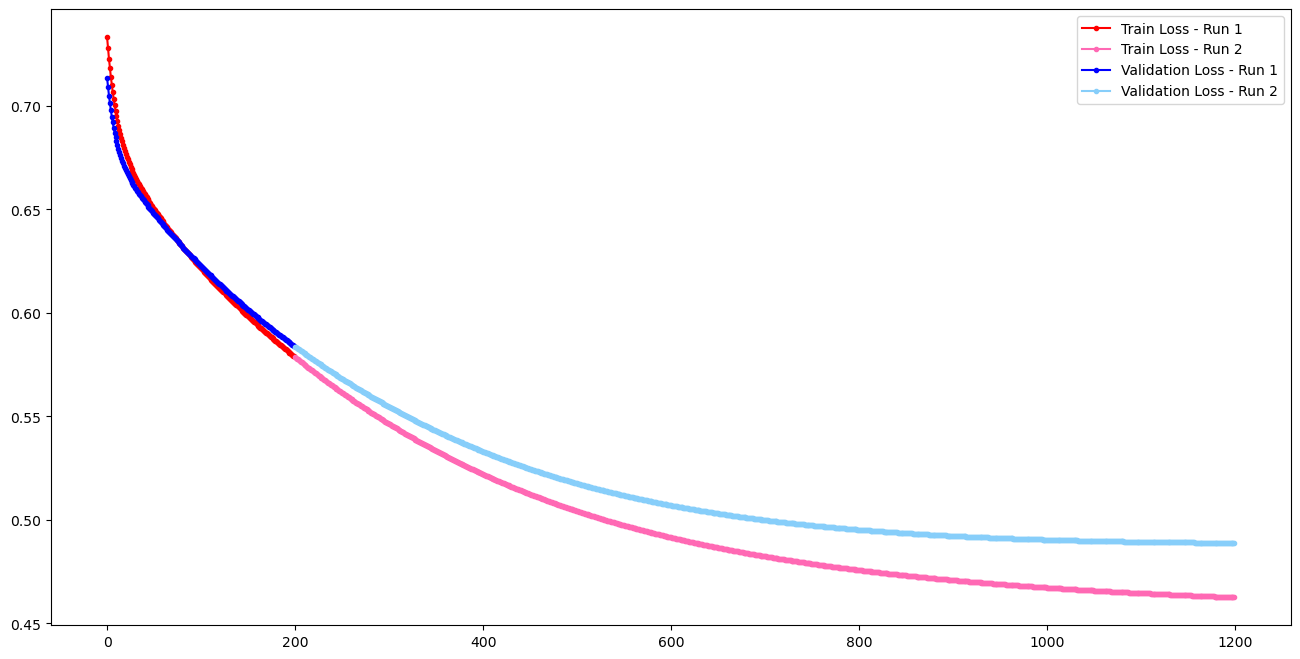

In [27]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?


## Exercise 2
For this exercise, do the following in the cells below:
- Build a model with two hidden layers, each with 6 nodes
- Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer
- Use a learning rate of .003 and train for 1500 epochs
- Graph the trajectory of the loss functions, accuracy on both train and test set
- Plot the roc curve for the predictions

Experiment with different learning rates, numbers of epochs, and network structures


In [30]:
### BEGIN SOLUTION
model_2 = Sequential()
model_2.add(Dense(6, input_shape=(8,), activation="relu"))
model_2.add(Dense(6,  activation="relu"))
model_2.add(Dense(1, activation="sigmoid"))

model_2.compile(optimizer = SGD(learning_rate = 0.003), loss = "binary_crossentropy", metrics=["accuracy"])
run_hist_2 = model_2.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1500)

Epoch 1/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4841 - loss: 0.7148 - val_accuracy: 0.4844 - val_loss: 0.7031
Epoch 2/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5155 - loss: 0.7066 - val_accuracy: 0.5208 - val_loss: 0.6997
Epoch 3/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4988 - loss: 0.7096 - val_accuracy: 0.5417 - val_loss: 0.6964
Epoch 4/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5245 - loss: 0.6987 - val_accuracy: 0.5573 - val_loss: 0.6933
Epoch 5/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5395 - loss: 0.6865 - val_accuracy: 0.5833 - val_loss: 0.6903
Epoch 6/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5764 - loss: 0.6771 - val_accuracy: 0.5885 - val_loss: 0.6875
Epoch 7/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5617 - loss: 0.6898 - val_accuracy: 0.5938 - val_loss: 0.6847
Epoch 8/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5591 - loss: 0.6867 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7817 - loss: 0.5073 - val_accuracy: 0.7292 - val_loss: 0.5512
Epoch 102/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7571 - loss: 0.5232 - val_accuracy: 0.7292 - val_loss: 0.5503
Epoch 103/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7707 - loss: 0.5103 - val_accuracy: 0.7292 - val_loss: 0.5495
Epoch 104/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7577 - loss: 0.5215 - val_accuracy: 0.7344 - val_loss: 0.5487
Epoch 105/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7506 - loss: 0.5165 - val_accuracy: 0.7344 - val_loss: 0.5478
Epoch 106/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7745 - loss: 0.5072 - val_accuracy: 0.7344 - val_loss: 0.5470
Epoch 107/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7466 - loss: 0.5317 - val_accuracy: 0.7292 - val_loss: 0.5463
Epoch 108/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7580 - loss: 0.5265 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7793 - loss: 0.4836 - val_accuracy: 0.7396 - val_loss: 0.5224
Epoch 152/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7622 - loss: 0.4813 - val_accuracy: 0.7396 - val_loss: 0.5220
Epoch 153/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7874 - loss: 0.4616 - val_accuracy: 0.7344 - val_loss: 0.5217
Epoch 154/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7841 - loss: 0.4636 - val_accuracy: 0.7344 - val_loss: 0.5213
Epoch 155/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7593 - loss: 0.5009 - val_accuracy: 0.7344 - val_loss: 0.5210
Epoch 156/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7686 - loss: 0.4728 - val_accuracy: 0.7344 - val_loss: 0.5207
Epoch 157/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7786 - loss: 0.4822 - val_accuracy: 0.7344 - val_loss: 0.5204
Epoch 158/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7956 - loss: 0.4644 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8262 - loss: 0.4214 - val_accuracy: 0.7344 - val_loss: 0.5134
Epoch 202/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8158 - loss: 0.4504 - val_accuracy: 0.7344 - val_loss: 0.5134
Epoch 203/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8071 - loss: 0.4489 - val_accuracy: 0.7344 - val_loss: 0.5133
Epoch 204/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7928 - loss: 0.4599 - val_accuracy: 0.7344 - val_loss: 0.5133
Epoch 205/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7993 - loss: 0.4446 - val_accuracy: 0.7344 - val_loss: 0.5132
Epoch 206/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7885 - loss: 0.4601 - val_accuracy: 0.7344 - val_loss: 0.5132
Epoch 207/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8254 - loss: 0.4381 - val_accuracy: 0.7344 - val_loss: 0.5131
Epoch 208/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7764 - loss: 0.4670 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8089 - loss: 0.4541 - val_accuracy: 0.7344 - val_loss: 0.5123
Epoch 252/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8029 - loss: 0.4534 - val_accuracy: 0.7344 - val_loss: 0.5123
Epoch 253/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7805 - loss: 0.4861 - val_accuracy: 0.7344 - val_loss: 0.5123
Epoch 254/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7777 - loss: 0.4620 - val_accuracy: 0.7344 - val_loss: 0.5122
Epoch 255/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7977 - loss: 0.4545 - val_accuracy: 0.7344 - val_loss: 0.5122
Epoch 256/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7989 - loss: 0.4399 - val_accuracy: 0.7344 - val_loss: 0.5122
Epoch 257/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7937 - loss: 0.4464 - val_accuracy: 0.7396 - val_loss: 0.5122
Epoch 258/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7900 - loss: 0.4663 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7934 - loss: 0.4427 - val_accuracy: 0.7344 - val_loss: 0.5119
Epoch 302/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7674 - loss: 0.4766 - val_accuracy: 0.7344 - val_loss: 0.5119
Epoch 303/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8176 - loss: 0.4133 - val_accuracy: 0.7344 - val_loss: 0.5119
Epoch 304/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7983 - loss: 0.4543 - val_accuracy: 0.7344 - val_loss: 0.5119
Epoch 305/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8124 - loss: 0.4290 - val_accuracy: 0.7344 - val_loss: 0.5119
Epoch 306/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8050 - loss: 0.4321 - val_accuracy: 0.7344 - val_loss: 0.5119
Epoch 307/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7951 - loss: 0.4474 - val_accuracy: 0.7344 - val_loss: 0.5118
Epoch 308/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7939 - loss: 0.4494 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8093 - loss: 0.4238 - val_accuracy: 0.7396 - val_loss: 0.5114
Epoch 352/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8004 - loss: 0.4363 - val_accuracy: 0.7396 - val_loss: 0.5115
Epoch 353/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7837 - loss: 0.4614 - val_accuracy: 0.7396 - val_loss: 0.5115
Epoch 354/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7996 - loss: 0.4339 - val_accuracy: 0.7396 - val_loss: 0.5115
Epoch 355/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8228 - loss: 0.4108 - val_accuracy: 0.7396 - val_loss: 0.5115
Epoch 356/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7696 - loss: 0.4726 - val_accuracy: 0.7396 - val_loss: 0.5115
Epoch 357/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7986 - loss: 0.4339 - val_accuracy: 0.7396 - val_loss: 0.5115
Epoch 358/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7847 - loss: 0.4348 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7992 - loss: 0.4216 - val_accuracy: 0.7448 - val_loss: 0.5119
Epoch 402/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7921 - loss: 0.4359 - val_accuracy: 0.7448 - val_loss: 0.5120
Epoch 403/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7908 - loss: 0.4258 - val_accuracy: 0.7448 - val_loss: 0.5120
Epoch 404/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7884 - loss: 0.4304 - val_accuracy: 0.7448 - val_loss: 0.5120
Epoch 405/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7806 - loss: 0.4328 - val_accuracy: 0.7448 - val_loss: 0.5120
Epoch 406/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7868 - loss: 0.4474 - val_accuracy: 0.7448 - val_loss: 0.5120
Epoch 407/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7970 - loss: 0.4227 - val_accuracy: 0.7448 - val_loss: 0.5120
Epoch 408/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7950 - loss: 0.4195 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7929 - loss: 0.4454 - val_accuracy: 0.7500 - val_loss: 0.5122
Epoch 452/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7887 - loss: 0.4346 - val_accuracy: 0.7500 - val_loss: 0.5122
Epoch 453/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7933 - loss: 0.4245 - val_accuracy: 0.7500 - val_loss: 0.5122
Epoch 454/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7910 - loss: 0.4130 - val_accuracy: 0.7500 - val_loss: 0.5122
Epoch 455/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7622 - loss: 0.4818 - val_accuracy: 0.7500 - val_loss: 0.5122
Epoch 456/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7815 - loss: 0.4314 - val_accuracy: 0.7500 - val_loss: 0.5122
Epoch 457/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7889 - loss: 0.4372 - val_accuracy: 0.7500 - val_loss: 0.5122
Epoch 458/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7844 - loss: 0.4610 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8101 - loss: 0.4271 - val_accuracy: 0.7604 - val_loss: 0.5123
Epoch 502/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8092 - loss: 0.4226 - val_accuracy: 0.7604 - val_loss: 0.5123
Epoch 503/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7967 - loss: 0.4187 - val_accuracy: 0.7604 - val_loss: 0.5122
Epoch 504/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7876 - loss: 0.4457 - val_accuracy: 0.7604 - val_loss: 0.5122
Epoch 505/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7833 - loss: 0.4391 - val_accuracy: 0.7604 - val_loss: 0.5123
Epoch 506/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7875 - loss: 0.4533 - val_accuracy: 0.7604 - val_loss: 0.5123
Epoch 507/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8172 - loss: 0.4053 - val_accuracy: 0.7604 - val_loss: 0.5123
Epoch 508/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8012 - loss: 0.4280 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7543 - loss: 0.4749 - val_accuracy: 0.7604 - val_loss: 0.5126
Epoch 552/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8020 - loss: 0.4132 - val_accuracy: 0.7604 - val_loss: 0.5126
Epoch 553/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7771 - loss: 0.4474 - val_accuracy: 0.7604 - val_loss: 0.5126
Epoch 554/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7737 - loss: 0.4426 - val_accuracy: 0.7604 - val_loss: 0.5126
Epoch 555/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7903 - loss: 0.4281 - val_accuracy: 0.7604 - val_loss: 0.5126
Epoch 556/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7984 - loss: 0.4281 - val_accuracy: 0.7604 - val_loss: 0.5126
Epoch 557/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8062 - loss: 0.4306 - val_accuracy: 0.7604 - val_loss: 0.5126
Epoch 558/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7864 - loss: 0.4428 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8144 - loss: 0.4121 - val_accuracy: 0.7552 - val_loss: 0.5130
Epoch 602/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7943 - loss: 0.4274 - val_accuracy: 0.7552 - val_loss: 0.5130
Epoch 603/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7908 - loss: 0.4294 - val_accuracy: 0.7552 - val_loss: 0.5130
Epoch 604/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7984 - loss: 0.4215 - val_accuracy: 0.7552 - val_loss: 0.5130
Epoch 605/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8017 - loss: 0.4410 - val_accuracy: 0.7552 - val_loss: 0.5130
Epoch 606/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8017 - loss: 0.4263 - val_accuracy: 0.7552 - val_loss: 0.5130
Epoch 607/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7737 - loss: 0.4669 - val_accuracy: 0.7552 - val_loss: 0.5131
Epoch 608/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7893 - loss: 0.4416 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7839 - loss: 0.4646 - val_accuracy: 0.7604 - val_loss: 0.5135
Epoch 652/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8025 - loss: 0.4031 - val_accuracy: 0.7604 - val_loss: 0.5135
Epoch 653/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8071 - loss: 0.4246 - val_accuracy: 0.7604 - val_loss: 0.5135
Epoch 654/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8156 - loss: 0.4104 - val_accuracy: 0.7604 - val_loss: 0.5135
Epoch 655/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8007 - loss: 0.4296 - val_accuracy: 0.7604 - val_loss: 0.5135
Epoch 656/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8025 - loss: 0.4007 - val_accuracy: 0.7604 - val_loss: 0.5135
Epoch 657/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7886 - loss: 0.4470 - val_accuracy: 0.7604 - val_loss: 0.5136
Epoch 658/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7766 - loss: 0.4450 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7886 - loss: 0.4487 - val_accuracy: 0.7656 - val_loss: 0.5142
Epoch 702/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7775 - loss: 0.4440 - val_accuracy: 0.7656 - val_loss: 0.5143
Epoch 703/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7918 - loss: 0.4168 - val_accuracy: 0.7656 - val_loss: 0.5143
Epoch 704/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7996 - loss: 0.4297 - val_accuracy: 0.7656 - val_loss: 0.5143
Epoch 705/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8051 - loss: 0.4177 - val_accuracy: 0.7656 - val_loss: 0.5143
Epoch 706/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7670 - loss: 0.4722 - val_accuracy: 0.7656 - val_loss: 0.5143
Epoch 707/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8265 - loss: 0.3878 - val_accuracy: 0.7656 - val_loss: 0.5144
Epoch 708/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8004 - loss: 0.4362 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7972 - loss: 0.4171 - val_accuracy: 0.7656 - val_loss: 0.5152
Epoch 752/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8086 - loss: 0.4082 - val_accuracy: 0.7656 - val_loss: 0.5152
Epoch 753/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8116 - loss: 0.3983 - val_accuracy: 0.7656 - val_loss: 0.5152
Epoch 754/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8083 - loss: 0.4030 - val_accuracy: 0.7656 - val_loss: 0.5152
Epoch 755/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7890 - loss: 0.4476 - val_accuracy: 0.7656 - val_loss: 0.5153
Epoch 756/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7839 - loss: 0.4657 - val_accuracy: 0.7656 - val_loss: 0.5153
Epoch 757/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7934 - loss: 0.4340 - val_accuracy: 0.7656 - val_loss: 0.5153
Epoch 758/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8058 - loss: 0.4095 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8177 - loss: 0.4082 - val_accuracy: 0.7656 - val_loss: 0.5164
Epoch 802/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8149 - loss: 0.4078 - val_accuracy: 0.7656 - val_loss: 0.5164
Epoch 803/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7892 - loss: 0.4403 - val_accuracy: 0.7656 - val_loss: 0.5164
Epoch 804/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8025 - loss: 0.4269 - val_accuracy: 0.7656 - val_loss: 0.5164
Epoch 805/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7915 - loss: 0.4484 - val_accuracy: 0.7656 - val_loss: 0.5165
Epoch 806/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8076 - loss: 0.4200 - val_accuracy: 0.7656 - val_loss: 0.5165
Epoch 807/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8046 - loss: 0.4093 - val_accuracy: 0.7656 - val_loss: 0.5165
Epoch 808/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7851 - loss: 0.4560 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8056 - loss: 0.3973 - val_accuracy: 0.7656 - val_loss: 0.5171
Epoch 852/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7757 - loss: 0.4572 - val_accuracy: 0.7656 - val_loss: 0.5172
Epoch 853/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7911 - loss: 0.4292 - val_accuracy: 0.7656 - val_loss: 0.5171
Epoch 854/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8282 - loss: 0.3897 - val_accuracy: 0.7656 - val_loss: 0.5171
Epoch 855/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7723 - loss: 0.4640 - val_accuracy: 0.7656 - val_loss: 0.5172
Epoch 856/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8140 - loss: 0.3941 - val_accuracy: 0.7656 - val_loss: 0.5172
Epoch 857/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7964 - loss: 0.4075 - val_accuracy: 0.7656 - val_loss: 0.5172
Epoch 858/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7903 - loss: 0.4446 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8125 - loss: 0.4157 - val_accuracy: 0.7604 - val_loss: 0.5182
Epoch 902/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7987 - loss: 0.4169 - val_accuracy: 0.7604 - val_loss: 0.5183
Epoch 903/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8145 - loss: 0.4063 - val_accuracy: 0.7604 - val_loss: 0.5183
Epoch 904/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7988 - loss: 0.4236 - val_accuracy: 0.7604 - val_loss: 0.5183
Epoch 905/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8083 - loss: 0.4093 - val_accuracy: 0.7604 - val_loss: 0.5184
Epoch 906/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8124 - loss: 0.4036 - val_accuracy: 0.7604 - val_loss: 0.5184
Epoch 907/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8019 - loss: 0.4081 - val_accuracy: 0.7604 - val_loss: 0.5184
Epoch 908/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7822 - loss: 0.4556 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8055 - loss: 0.4043 - val_accuracy: 0.7604 - val_loss: 0.5197
Epoch 952/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7861 - loss: 0.4630 - val_accuracy: 0.7604 - val_loss: 0.5197
Epoch 953/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7888 - loss: 0.4319 - val_accuracy: 0.7604 - val_loss: 0.5197
Epoch 954/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7868 - loss: 0.4130 - val_accuracy: 0.7604 - val_loss: 0.5197
Epoch 955/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7772 - loss: 0.4406 - val_accuracy: 0.7604 - val_loss: 0.5198
Epoch 956/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8024 - loss: 0.4131 - val_accuracy: 0.7604 - val_loss: 0.5198
Epoch 957/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8153 - loss: 0.4113 - val_accuracy: 0.7604 - val_loss: 0.5198
Epoch 958/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7862 - loss: 0.4370 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7942 - loss: 0.4062 - val_accuracy: 0.7604 - val_loss: 0.5207
Epoch 1002/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7993 - loss: 0.4475 - val_accuracy: 0.7604 - val_loss: 0.5207
Epoch 1003/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7850 - loss: 0.4519 - val_accuracy: 0.7604 - val_loss: 0.5208
Epoch 1004/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8013 - loss: 0.4196 - val_accuracy: 0.7604 - val_loss: 0.5208
Epoch 1005/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8113 - loss: 0.4019 - val_accuracy: 0.7604 - val_loss: 0.5208
Epoch 1006/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8233 - loss: 0.3881 - val_accuracy: 0.7604 - val_loss: 0.5208
Epoch 1007/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8001 - loss: 0.4136 - val_accuracy: 0.7604 - val_loss: 0.5208
Epoch 1008/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8054 - loss: 0.4135 - val_accu

Epoch 1051/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7854 - loss: 0.4352 - val_accuracy: 0.7604 - val_loss: 0.5217
Epoch 1052/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8050 - loss: 0.4271 - val_accuracy: 0.7604 - val_loss: 0.5217
Epoch 1053/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7864 - loss: 0.4224 - val_accuracy: 0.7604 - val_loss: 0.5217
Epoch 1054/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7955 - loss: 0.4160 - val_accuracy: 0.7604 - val_loss: 0.5217
Epoch 1055/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7860 - loss: 0.4407 - val_accuracy: 0.7604 - val_loss: 0.5217
Epoch 1056/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8033 - loss: 0.4093 - val_accuracy: 0.7604 - val_loss: 0.5218
Epoch 1057/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8101 - loss: 0.3913 - val_accuracy: 0.7604 - val_loss: 0.5217
Epoch 1058/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8037 - loss: 0

Epoch 1150/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8149 - loss: 0.4160 - val_accuracy: 0.7656 - val_loss: 0.5236
Epoch 1151/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8088 - loss: 0.4117 - val_accuracy: 0.7656 - val_loss: 0.5236
Epoch 1152/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8120 - loss: 0.4044 - val_accuracy: 0.7656 - val_loss: 0.5237
Epoch 1153/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7795 - loss: 0.4357 - val_accuracy: 0.7656 - val_loss: 0.5237
Epoch 1154/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8071 - loss: 0.4206 - val_accuracy: 0.7656 - val_loss: 0.5237
Epoch 1155/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7771 - loss: 0.4364 - val_accuracy: 0.7656 - val_loss: 0.5237
Epoch 1156/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8245 - loss: 0.3903 - val_accuracy: 0.7656 - val_loss: 0.5237
Epoch 1157/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8114 - loss: 0

Epoch 1249/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8200 - loss: 0.4011 - val_accuracy: 0.7708 - val_loss: 0.5260
Epoch 1250/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8244 - loss: 0.3973 - val_accuracy: 0.7708 - val_loss: 0.5259
Epoch 1251/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8151 - loss: 0.4007 - val_accuracy: 0.7708 - val_loss: 0.5260
Epoch 1252/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8024 - loss: 0.4096 - val_accuracy: 0.7708 - val_loss: 0.5260
Epoch 1253/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7864 - loss: 0.4356 - val_accuracy: 0.7708 - val_loss: 0.5260
Epoch 1254/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7716 - loss: 0.4452 - val_accuracy: 0.7708 - val_loss: 0.5261
Epoch 1255/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8050 - loss: 0.4066 - val_accuracy: 0.7708 - val_loss: 0.5261
Epoch 1256/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8042 - loss: 0

Epoch 1348/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8330 - loss: 0.3820 - val_accuracy: 0.7708 - val_loss: 0.5280
Epoch 1349/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8273 - loss: 0.3916 - val_accuracy: 0.7708 - val_loss: 0.5280
Epoch 1350/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7885 - loss: 0.4433 - val_accuracy: 0.7708 - val_loss: 0.5280
Epoch 1351/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8075 - loss: 0.4175 - val_accuracy: 0.7708 - val_loss: 0.5280
Epoch 1352/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7969 - loss: 0.4242 - val_accuracy: 0.7708 - val_loss: 0.5280
Epoch 1353/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8007 - loss: 0.4264 - val_accuracy: 0.7708 - val_loss: 0.5280
Epoch 1354/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8131 - loss: 0.3946 - val_accuracy: 0.7708 - val_loss: 0.5280
Epoch 1355/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8066 - loss: 0

Epoch 1447/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8016 - loss: 0.4097 - val_accuracy: 0.7708 - val_loss: 0.5289
Epoch 1448/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7982 - loss: 0.4127 - val_accuracy: 0.7708 - val_loss: 0.5289
Epoch 1449/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7929 - loss: 0.4164 - val_accuracy: 0.7708 - val_loss: 0.5289
Epoch 1450/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8190 - loss: 0.3899 - val_accuracy: 0.7708 - val_loss: 0.5288
Epoch 1451/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8092 - loss: 0.4079 - val_accuracy: 0.7708 - val_loss: 0.5288
Epoch 1452/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7789 - loss: 0.4414 - val_accuracy: 0.7708 - val_loss: 0.5288
Epoch 1453/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8021 - loss: 0.4074 - val_accuracy: 0.7708 - val_loss: 0.5288
Epoch 1454/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8056 - loss: 0

In [31]:
run_hist_2.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Text(0.5, 1.0, 'Accuracy over iterations')

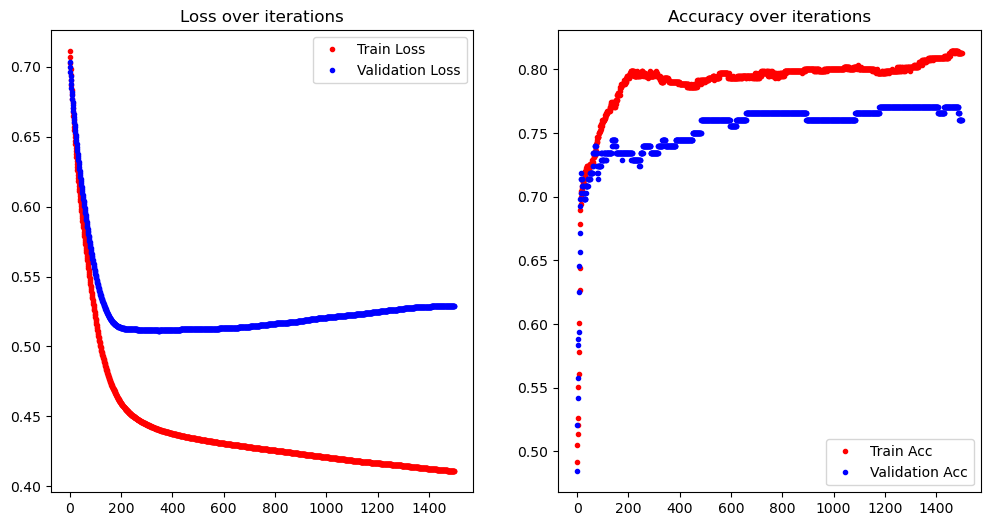

In [34]:
n = len(run_hist_2.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (run_hist_2.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (run_hist_2.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (run_hist_2.history["accuracy"]),'r.', label="Train Acc")
ax.plot(range(n), (run_hist_2.history["val_accuracy"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

accuracy is 0.760
roc-auc is 0.802


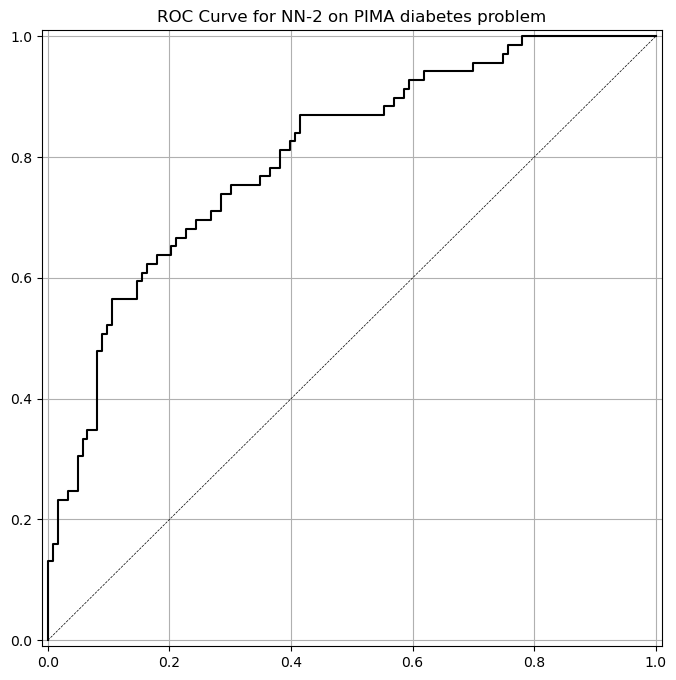

In [41]:
y_pred_prob_nn_2 = model_2.predict(X_test_norm)  # Probabilities
y_pred_class_nn_2 = (y_pred_prob_nn_3 > 0.5).astype(int)  # Convert to class labels
print('')
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_2)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_2)))

plot_roc(y_test, y_pred_prob_nn_2, 'NN-2')
### END SOLUTION

---
### Machine Learning Foundation (C) 2020 IBM Corporation
